The goal of this project is to predict whether each image has any tumor tissue. The competition can be found at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.

In [18]:
from glob import glob
import numpy as np
import pandas as pd
import keras,cv2,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
competition_name = "histopathologic-cancer-detection"

from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/Colab Notebooks/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c {competition_name}

! mkdir kaggle_data
! unzip {competition_name + ".zip"} -d kaggle_data

drive.flush_and_unmount()

In [2]:
path = "/content/kaggle_data/"
train_path = path + "train/"
test_path = path + "test/"

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv("/content/kaggle_data/train_labels.csv")
df = df.merge(labels, on = "id")
df.head(3)

,path,id,label
0,/content/kaggle_data/train/cce846997ce58c2aeba...,cce846997ce58c2aeba57ca625112b3d40c118dd,1
1,/content/kaggle_data/train/fc4b319d20d67f6884b...,fc4b319d20d67f6884b1703678f054cd8a29e04c,0
2,/content/kaggle_data/train/110206c49383d12d6e8...,110206c49383d12d6e8c3f4f51b9d3fc9bbcaffe,1


In [3]:
def load_data(N,df):

    X = np.zeros([N,96,96,3],dtype=np.uint8)
    y = np.squeeze(df["label"].values[0:N])

    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    return X,y

In [4]:
N=10000
X,y = load_data(N=N,df=df)

<ipython-input-3-7322784a46dc>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
X.shape

(220025, 96, 96, 3)

In [24]:
X[0]

array([[[255, 248, 253],
        [255, 250, 251],
        [252, 251, 247],
        ...,
        [203, 185, 214],
        [236, 221, 253],
        [187, 170, 207]],

       [[250, 244, 249],
        [253, 248, 249],
        [251, 250, 246],
        ...,
        [217, 199, 230],
        [231, 214, 247],
        [189, 172, 209]],

       [[250, 246, 251],
        [254, 252, 252],
        [251, 252, 248],
        ...,
        [202, 183, 216],
        [217, 200, 234],
        [205, 187, 226]],

       ...,

       [[229, 218, 244],
        [218, 204, 240],
        [169, 147, 199],
        ...,
        [230, 210, 255],
        [228, 215, 255],
        [216, 206, 249]],

       [[219, 211, 228],
        [214, 202, 232],
        [223, 206, 250],
        ...,
        [238, 218, 255],
        [200, 184, 231],
        [184, 173, 219]],

       [[236, 229, 242],
        [156, 145, 171],
        [219, 202, 245],
        ...,
        [200, 178, 227],
        [226, 210, 255],
        [220, 208, 255]]

In [22]:
y.shape

(220025,)

In [32]:
y[0:10]

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

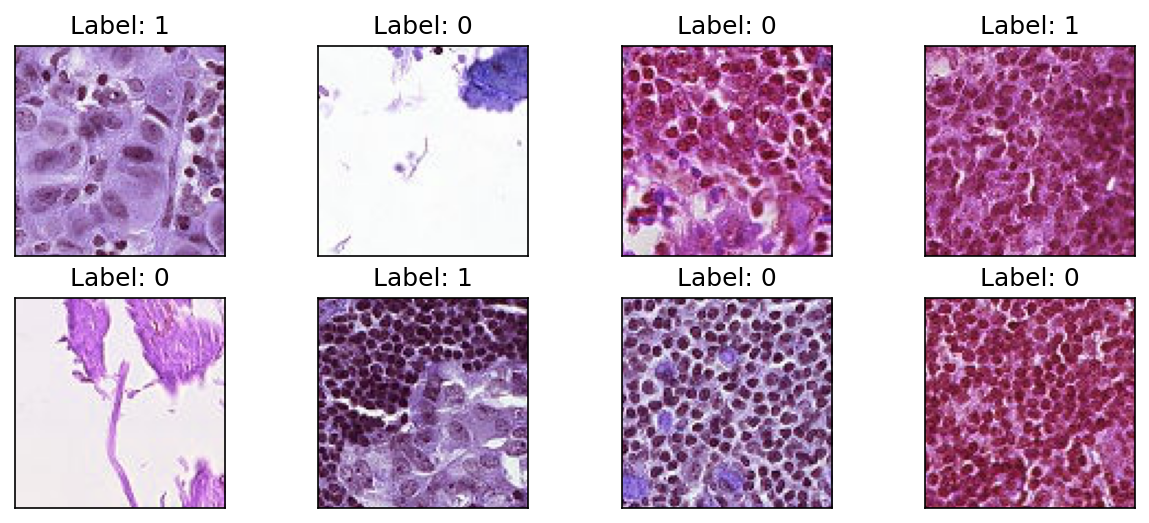

In [5]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100)
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[])
    plt.imshow(X[idx])
    ax.set_title('Label: ' + str(y[idx]))

Text(0, 0.5, '# of samples')

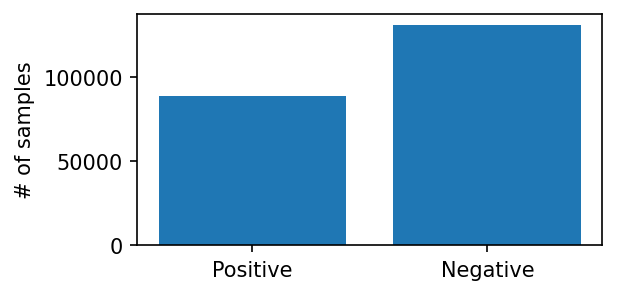

In [31]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]);
plt.xticks([1,0],["Negative","Positive"]);
plt.ylabel("# of samples")

In [7]:
N = df["path"].size
X,y = load_data(N=N,df=df)

<ipython-input-3-7322784a46dc>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/220025 [00:00<?, ?it/s]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I decide to go with a CNN architecture which has 3 convolution blocks and utilizes dropout for regularization. I use "relu" activation functions and max pooling. In the output layer, I use a "sigmoid" function to make the classification. During training, I use early stoppage which automatically stops training if the validation accuracy doesn't increase over a period of 3 epochs. This way, the model does not over-fit.

In [9]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))

In [10]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

In [11]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [12]:
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = [es])

Epoch 1/100
1761/1761 [==============================] - 87s 43ms/step - loss: 0.3384 - accuracy: 0.8566 - val_loss: 0.4345 - val_accuracy: 0.8354
Epoch 2/100
1761/1761 [==============================] - 73s 42ms/step - loss: 0.2436 - accuracy: 0.9028 - val_loss: 0.4061 - val_accuracy: 0.8408
Epoch 3/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.2058 - accuracy: 0.9203 - val_loss: 0.5309 - val_accuracy: 0.8226
Epoch 4/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.1844 - accuracy: 0.9295 - val_loss: 0.2560 - val_accuracy: 0.8949
Epoch 5/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.1711 - accuracy: 0.9351 - val_loss: 0.2177 - val_accuracy: 0.9171
Epoch 6/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.1605 - accuracy: 0.9397 - val_loss: 0.6307 - val_accuracy: 0.7912
Epoch 7/100
1761/1761 [==============================] - 72s 41ms/step - loss: 0.1508 - accuracy: 0.9436 - val_loss: 0

In [13]:
model.evaluate(X_test, y_test)

1376/1376 [==============================] - 6s 4ms/step - loss: 0.3684 - accuracy: 0.8575


[0.3683735430240631, 0.8575161695480347]

In [14]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

1376/1376 [==============================] - 5s 3ms/step


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     26304
           1       0.75      0.96      0.84     17701

    accuracy                           0.86     44005
   macro avg       0.86      0.87      0.86     44005
weighted avg       0.88      0.86      0.86     44005



<Axes: >

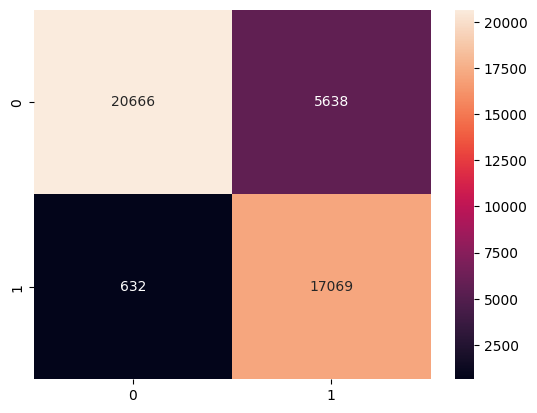

In [15]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="g")

In [20]:
base_test_dir = path + 'test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 10000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0])
    test_df['image'] = test_df['path'].map(cv2.imread)
    K_test = np.stack(test_df["image"].values)
    predictions = model.predict(K_test,verbose = 1)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

234/234 [==============================] - 1s 4ms/step


,id,label
0,3f3505be3b8ccb5863388251944b9ead101682a0,0.227486
1,29e2777be8a100395ecaf1e9d9bc478c09f4591a,0.010438
2,5f188e71de5bf14579b6a121fe594a19c1f0ffdb,0.145300
3,ce87fd2b6e3a42d62f4fb6ad635e29ecc3f56410,0.261295
4,5a8e36691f10ae0e5f4ca75543fdc1350a7ba0fc,0.513387


In [17]:
submission.to_csv("submission.csv", index = False, header = True)

In conclusion, my model performed with a 85.75% accuracy on the test set (which I created from 20% of the orginal training data during my train test split). The F1 score was 86%. I am very pleased with these results considering how complex the images are. Originally, I tried a higher dropout of 50% (compared to the current 20%), but that higher dropout performed worse so I decreased it. Since there were over 200,000 images, I did not use data augmentation, but to improve results I can use data augmentation to create even more training data, which may improve results but will take a longer time to train. My submission predictions achieved a public score of 93.91% on Kaggle which I am very pleased with.